In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import *

import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

### Reducing complexity

* Tying the parameters (parameter sharing)
* Reduce the connections in bayesian network (independence)
* Parameterization (approximation) instead of full distribution

### Show linear gaussian model

### Show discrete model

In [ ]:
# Models for generating data
# Models for deducing data (from bayesian networks)
# Show the denoising using random markov fields

<br>

# Markov Random Fields
---

**Undirected graph** in which the object of interest is the **maximum clique**. A clique is a sub-graph in which all the nodes are connected. The joint probability distribution in a Markov Random Field is defined as:

&emsp; $p(x) = \frac{1}{Z} \prod_C \psi_C(C)$, where $x$ is a vector of random variables

Where $Z$ is a normalizing constant, the partition function, $C$ are the maximum cliques, and $\psi_C$ is a **potential function** for a given clique (it does not have to be the same function for all cliques). These potential functions usually take the form of a **Boltzman distribution**, the exponential of a the negative of an **energy function**:

&emsp; $\psi_C(C) = e^{-E_C(C)}$

&emsp; $p(x) = \frac{1}{Z} e^{-\sum_C E_C(C)}$

This means that maximizing the probability of $x$ is equivalent to minimizing the sum of the energy. The goal is to select the right combination of energy function to represent our problem.

<br>

### Independence encoding

In a Markov Random Field, the **Markov Blanket**, i.e. the minimum set of nodes such that if a node is conditioned on these nodes, it is independant of every other nodes, is made of the neighbors of the nodes.

A maximum clique therefore represent a set of nodes for which it is impossible for two nodes to be independent of each other, whatever the number of variables we use to condion them.

In general, to make two nodes $x$ and $y$ independent, it is enough to condition on all nodes that cut all paths from $x$ to $y$. Searching for the minimum set of nodes can be done using the typical min-cut algorithm.

<br>

### Example: image denoising

We have an image $X$ that is unknown, made of pixels equal to -1 or 1, that is noised into an image $Y$ with random uniform change of flipping bits. The goal is to find the original image $X$ from the noised image $Y$.

To do so, we build a graph, where each variable $x_{ij}$ is a pixel that is either equal to -1 or 1, and where each pixel is related to its neighbor (tries to be similar), and related to the corresponding pixel $y_{ij}$ (tries to be similar as well).

&emsp; $E_{x_i y_i} = - \eta x_i y_i$ (tries to make sure both have same sign - could be kernel for similarity)

&emsp; $E_{x_i x_j} = - \beta x_i x_j$ (for neighbors)

&emsp; $E_{\text{total}} = \sum_i E_{x_i y_i} + \sum_i \sum_{j \in \text{neighbors}} E_{x_i x_j}$

Image denoising could be transformed into minimizing the energy $E_{\text{total}}$.

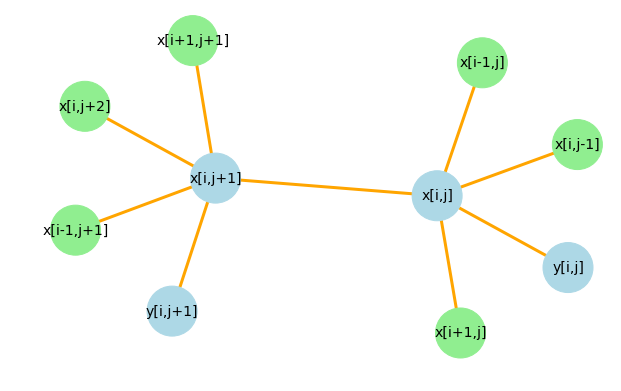

In [25]:
plt.figure(figsize=(8,5))

G = nx.Graph()
G.add_edge('x[i,j]', 'y[i,j]')
G.add_edge('x[i,j]', 'x[i-1,j]')
G.add_edge('x[i,j]', 'x[i+1,j]')
G.add_edge('x[i,j]', 'x[i,j-1]')
G.add_edge('x[i,j]', 'x[i,j+1]')
G.add_edge('x[i,j+1]', 'y[i,j+1]')
G.add_edge('x[i,j+1]', 'x[i,j+2]')
G.add_edge('x[i,j+1]', 'x[i+1,j+1]')
G.add_edge('x[i,j+1]', 'x[i-1,j+1]')

node_colors = []
for node_name, attr in G.nodes(data=True):
    if node_name.endswith('[i,j]'):
        node_colors.append('lightblue')
    elif node_name.endswith('[i,j+1]'):
        node_colors.append('lightblue')
    else:
        node_colors.append('lightgreen')
nx.draw_spring(G, with_labels=True, font_size=14, font_weight='normal', font_color='black',
        arrowsize=25, width=3, node_color=node_colors, node_size=2500, edge_color='orange')
plt.show()

<br>

### ICM (Iterative Conditional Modes) algorithm

To minimize the energy $E = E_{\text{total}}$, we can take a cue from **gradient descent** in optimization approaches:

&emsp; $\frac{\partial E}{\partial x_i} = - \eta y_i - \beta \sum_{j \in \text{neighbors}} x_j$

&emsp; $x_i^\text{new} \leftarrow x_i - \alpha \frac{\partial E}{\partial x_i}$

So basically, if the neighbors are mostly positive, $\frac{\partial E}{\partial x_i}$ is negative, and so $x_i$ should move to the positive direction. The idea is to adapt this gradient descent approach to the discrete case of pixel values that are either -1 or 1. The idea is to select the idea of $x_i$ that minimizes:

&emsp; $E_{x_i} = x_i (- \eta y_i - \beta \sum_{j \in \text{neighbors}} x_j) = x_i \frac{\partial E}{\partial x_i}$

Which is equivalent to taking the value that has a different sign than $\frac{\partial E}{\partial x_i}$. The algorithm consist in picking randomly pixels $x_i$ and applying this formula. As any stockastic gradient descent, this does not ensure we find the minimum (there are other better algorithms).

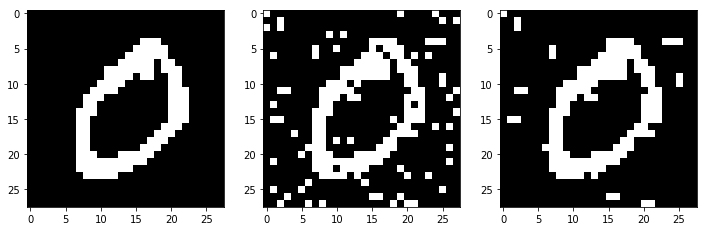

In [26]:
import torchvision

def to_tensor(image):
    return torchvision.transforms.ToTensor()(image)

def to_image(tensor):
    return torchvision.transforms.ToPILImage()(tensor)

# Getting an image
training_data_set = torchvision.datasets.MNIST('./dataset/mnist/training.pt', train=True, download=True)
original_image = training_data_set[1][0]
original_xs = to_tensor(original_image)
original_xs = torch.round(original_xs)
original_image = to_image(original_xs)

# Noising the image
noise = np.random.binomial(1, 0.1, size=original_xs.shape)
noised_xs = (original_xs + torch.from_numpy(noise)) % 2
noised_image = to_image(noised_xs)


def denoise(ys, eta: float, beta: float, n_iter: int):
    _, h, w = ys.shape
    ys = np.where(ys == 0, -1, 1)
    xs = ys.copy()
    for _ in range(n_iter):
        for i in range(h):
            for j in range(w):
                energy = - eta * ys[0,i,j]
                if i > 0:
                    energy += - beta * xs[0,i-1,j]
                if i < h - 1:
                    energy += - beta * xs[0,i+1,j]
                if j > 0:
                    energy += - beta * xs[0,i,j-1]
                if j < w - 1:
                    energy += - beta * xs[0,i,j+1]
                xs[0,i,j] = -1 if energy > 0 else 1
    return torch.FloatTensor(np.where(xs==-1, 0, 1))


denoised_xs = denoise(noised_xs, eta=2.1, beta=1., n_iter=20)
denoised_image = to_image(denoised_xs)
fig, ax = plt.subplots(figsize=(12, 8), ncols=3)
ax[0].imshow(original_image)
ax[1].imshow(noised_image)
ax[2].imshow(denoised_image)
plt.show()

<br>

### Better approaches at denoising

TODO

<br>

# Bayesian Networks
---

**Directed acyclic graph** (DAG) in which the objects of interest are the conditional probabililies. Note that the direction of the arrows does not necessarily represents causal effects. The joint probability distribution in a Bayesian Network is defined as:

&emsp; $p(x) = \prod_n p(x_n|\text{parents}(x_n))$

<br>

### Independence encoding

In a Bayesian Network, the notion of independence is more complicated that in Markov Random Fields, due to the **explaining away** effect. Blocking a path between two variables $x$ and $y$ requires a bit more caution.

For instance below, $a$ and $b$ are independant, but are not independent if we condition them on $c$, for $c$ is both influenced by $a$ and $b$. Indeed, fixing the outcomes, means that knowing $a$ gives us some information for $b$ (one "cause" means the other cause is less likely).

The **Markov Blanket** is also harder to specify, and is composed of:

* of all the parents of the node to isolate
* of all the children of the node to isolate
* of all the parents of the children of the nodes to isolate (because of the explaining away effect)

For instance in the graph below, the markov blanket of $a$ is made of all the nodes but node $e$.

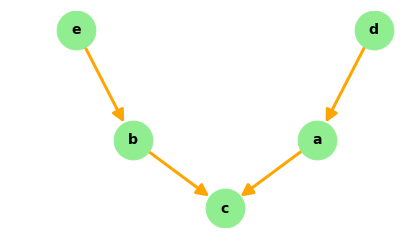

In [34]:
G = nx.DiGraph()
G.add_edge('a', 'c')
G.add_edge('b', 'c')
G.add_edge('d', 'a')
G.add_edge('e', 'b')

plt.figure(figsize=(5,3))
nx.draw_spectral(G, with_labels=True, font_size=14, font_weight='bold', font_color='black',
                 arrowsize=25, width=3, node_color='lightgreen', node_size=1500, edge_color='orange')

<br>

# Inference in graphical models
---

In the following model, we will use the following notations:

* $H$ stands for Hospitalized
* $C$ stands for Contaminated
* $S$ stands for Social Contacts
* $A$ stands for Age

Here is all our hypotheses:

* The age $A$ influences the behavior: elderly are more cautious than younger people
* The more social contacts $S$ you have, the higher the change of being contaminated $C$
* The probability of being hospitalized $H$ depends on the contamination $C$ and the age $A$ (young people are more resilient)

The is encoded in the Bayesian Network below, where arrows represent causal effects:

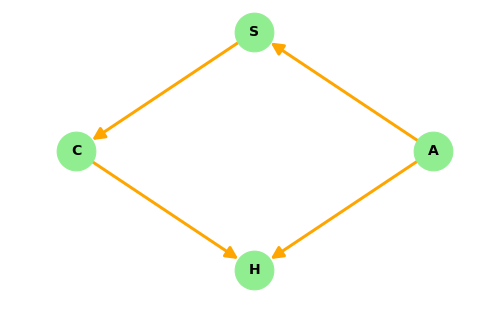

In [131]:
G = nx.DiGraph()
G.add_edge('A', 'S')
G.add_edge('S', 'C')
G.add_edge('A', 'H')
G.add_edge('C', 'H')
nx.draw_circular(G, with_labels=True, font_size=14, font_weight='bold', font_color='black',
                 arrowsize=25, width=3, node_color='lightgreen', node_size=1500, edge_color='orange')

We will also model the death rate from the virus by the following function:

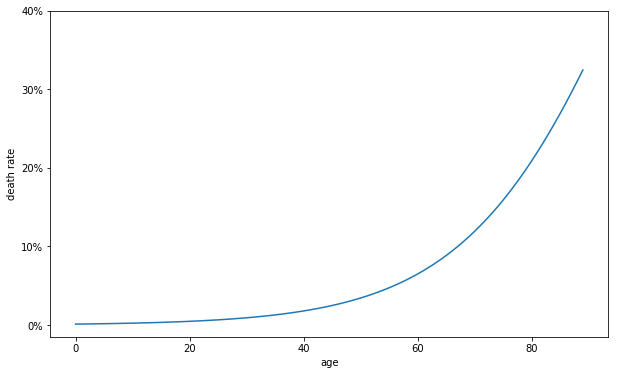

In [163]:
def documented_death_rate(age: int) -> float:
    return 1 / (1 + np.exp((100 - age) / 15))


ages = np.arange(0, 90, 1)
rates = documented_death_rate(ages)
rates_ticks = np.arange(0.0, 0.5, 0.1)
plt.figure(figsize=(10,6))
plt.plot(ages, rates)
plt.yticks(rates_ticks, ['{:,.0%}'.format(r) for r in rates_ticks])
plt.ylabel('death rate')
plt.xlabel('age')
plt.show()

Similarly, we will use the probability of contamination based on the number of social contacts, to be proportional to the number social contacts you have (obviously this is limited, we should look at the social network):

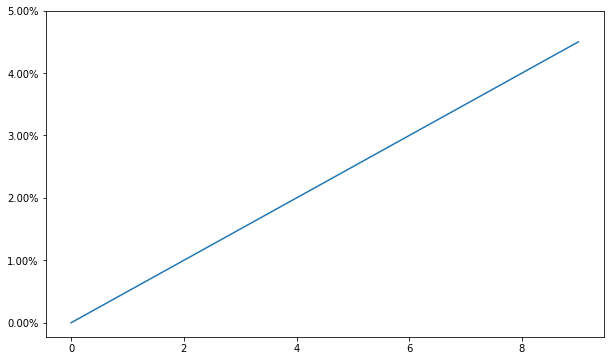

In [193]:
def prob_c_knowing_s(social: float) -> float:
    return 0.005 * social


social_contacts = np.arange(0, 10, 1)
contaminated_probs = prob_c_knowing_s(social_contacts)
contaminated_prob_ticks = np.arange(0.0, 0.06, 0.01)

plt.figure(figsize=(10,6))
plt.plot(social_contacts, contaminated_probs)
plt.yticks(contaminated_prob_ticks, ['{:,.2%}'.format(p) for p in contaminated_prob_ticks])
plt.show()

Probability of number of social contacts based on the age:

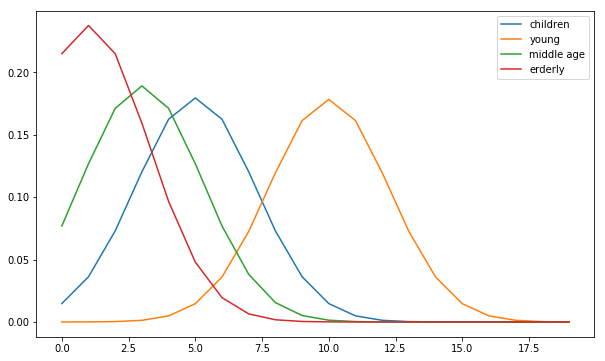

In [192]:
def mode_s_knowing_a(age: int) -> float:
    if age >= 70:
        return 1.0
    elif age >= 50:
        return 3.0
    elif age >= 20:
        return 10.0
    else:
        return 5.0


def prob_s_knowing_a(age: int) -> Tuple[np.ndarray, np.ndarray]:
    contacts = np.arange(0, 20, 1)
    mode = mode_s_knowing_a(age)
    densities = np.exp(- 0.1 * (contacts - mode)**2)
    densities /= np.sum(densities)
    return contacts, densities


plt.figure(figsize=(10,6))
plt.plot(*prob_s_knowing_a(10), label='children')
plt.plot(*prob_s_knowing_a(30), label='young')
plt.plot(*prob_s_knowing_a(50), label='middle age')
plt.plot(*prob_s_knowing_a(70), label='erderly')
plt.legend()
plt.show()

<br>

### Inference

Based on our Bayesian Network, we can decompose the joint probability as such:

&emsp; $\mathcal{P}(H,C,S,A) = \mathcal{P}(H|C,A) \mathcal{P}(C|S) \mathcal{P}(S|A) \mathcal{P}(A)$

Now, we can look at the probability that a person of a given age $A = a$ will be hospitalized, $\mathcal{P}(H|A=a)$. It is important to realize that this is different from $\mathcal{P}(H|C,A)$. We can find the exact formula by marginalizing:

&emsp; $\mathcal{P}(H|A) = \sum_C \mathcal{P}(H|C,A) \mathcal{P}(C|A) = \sum_C \mathcal{P}(H|C,A) \sum_S \mathcal{P}(C|S) \mathcal{P}(S|A)$

And the actual observations in the hospitals are $\mathcal{P}(H,A) = \mathcal{P}(H|A) \mathcal{P}(A)$.

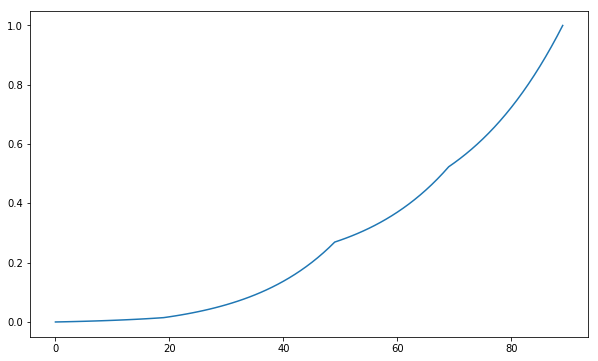

In [199]:
def prob_h_knowing_c_and_a(contaminated_prob: float, age: int) -> float:
    return documented_death_rate(age) * contaminated_prob


def prevision(age: int):
    contaminated_prob = 0.
    for social, social_prob in zip(*prob_s_knowing_a(age)):
        contaminated_prob += prob_c_knowing_s(social) * social_prob
    return prob_h_knowing_c_and_a(contaminated_prob, age)


ages = np.arange(0, 90, 1)
hospitalized = np.array([prevision(age) for age in ages])
hospitalized = np.cumsum(hospitalized / np.sum(hospitalized))
plt.figure(figsize=(10,6))
plt.plot(ages, hospitalized)
plt.show()

<br>

# Viterbi Algorithm
---

TODO